In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams 
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import xgboost as xgb

eng_stopwords = set(stopwords.words('english'))
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

d:\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
print(train_df.shape)
print(test_df.shape)

(404290, 6)
(2345796, 3)


In [3]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh - i - noor d...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 ^ 24 math is d...,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


**Data fields**

id - the id of a training set question pair

qid1, qid2 - unique ids of each question (only available in train.csv)

question1, question2 - the full text of each question

is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [4]:
test_df.head()

,test_id,question1,question2
0,0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...
1,1,should i have a hair transplant at age 24 how ...,how much cost does hair transplant require
2,2,what but is the best way to send money from ch...,what you send money to china
3,3,which food not emulsifiers,what foods fibre
4,4,how aberystwyth start reading,how their can i start reading


In [6]:
is_dup / is_dup.sum()

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

In [7]:
all_ques_df = pd.DataFrame(pd.concat([train_df['question1'], train_df['question2']]))
all_ques_df.columns = ["questions"]

all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))

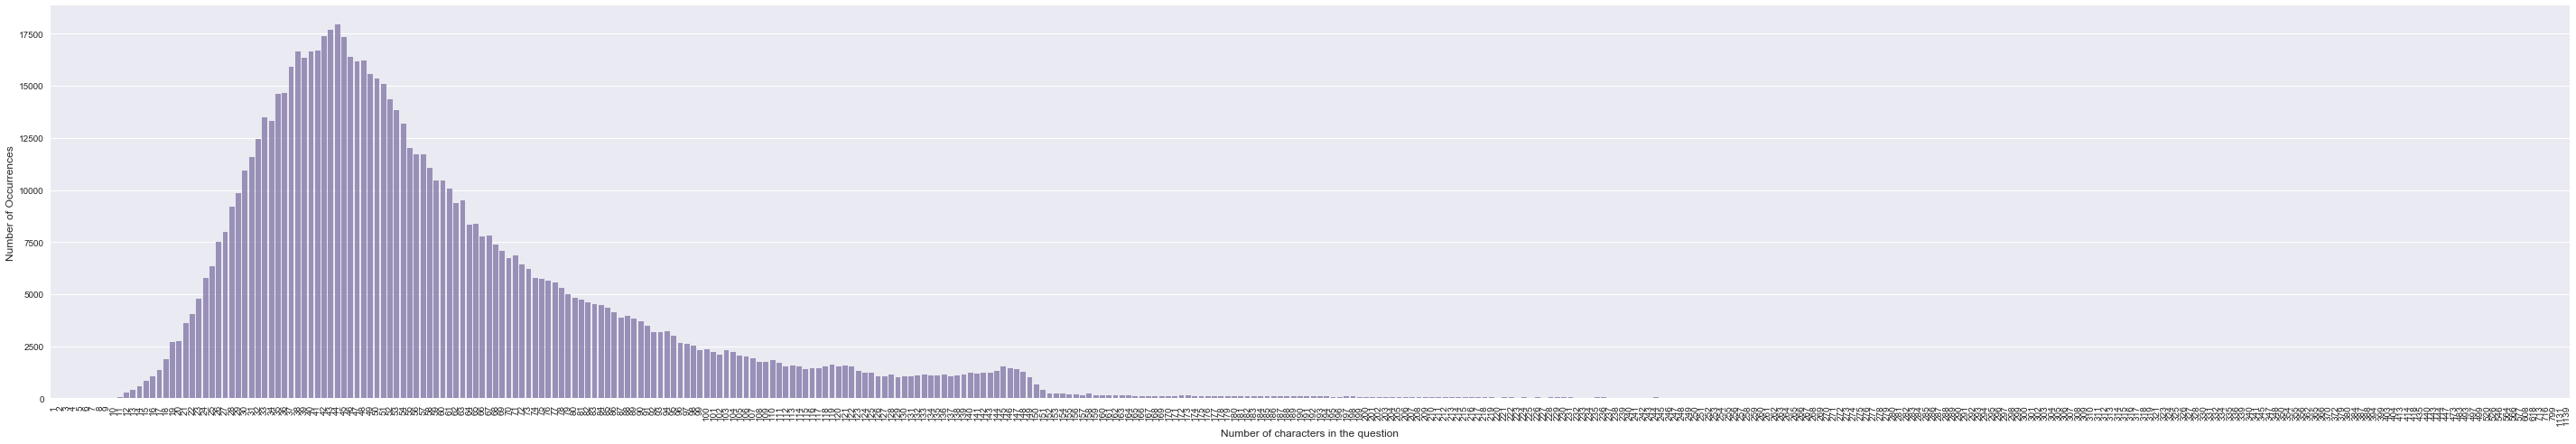

In [9]:
all_ques_df["num_of_chars"] = all_ques_df["questions"].apply(lambda x : len(str(x)))
cnt_srs = all_ques_df['num_of_chars'].value_counts()

plt.figure(figsize=(50,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of characters in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()      

del all_ques_df

## 几元模型特征的提取

In [11]:
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]#word_tokenize:对句子进行分词

def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )#取交集

def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

train_df["unigrams_ques1"] = train_df['question1'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_ques2"] = train_df['question2'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_common_count"] = train_df.apply(lambda row: get_common_unigrams(row),axis=1)
train_df["unigrams_common_ratio"] = train_df.apply(lambda row: get_common_unigram_ratio(row), axis=1)

In [16]:
def get_bigrams(que):
    return [i for i in ngrams(que, 2)]#组合分词

def get_common_bigrams(row):
    return len( set(row["bigrams_ques1"]).intersection(set(row["bigrams_ques2"])) )

def get_common_bigram_ratio(row):
    return float(row["bigrams_common_count"]) / max(len( set(row["bigrams_ques1"]).union(set(row["bigrams_ques2"])) ),1)

train_df["bigrams_ques1"] = train_df["unigrams_ques1"].apply(lambda x: get_bigrams(x))
train_df["bigrams_ques2"] = train_df["unigrams_ques2"].apply(lambda x: get_bigrams(x)) 
train_df["bigrams_common_count"] = train_df.apply(lambda row: get_common_bigrams(row),axis=1)
train_df["bigrams_common_ratio"] = train_df.apply(lambda row: get_common_bigram_ratio(row), axis=1)

In [21]:
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]#word_tokenize:对句子进行分词

def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )#取交集

def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

train_df["unigrams_ques1"] = train_df['question1'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_ques2"] = train_df['question2'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_common_count"] = train_df.apply(lambda row: get_common_unigrams(row),axis=1)
train_df["unigrams_common_ratio"] = train_df.apply(lambda row: get_common_unigram_ratio(row), axis=1)

In [22]:
def feature_extraction(row):
    que1 = str(row['question1'])
    que2 = str(row['question2'])
    out_list = []
    # get unigram features #
    unigrams_que1 = [word for word in word_tokenize(que1.lower()) if word not in eng_stopwords]
    unigrams_que2 = [word for word in word_tokenize(que2.lower()) if word not in eng_stopwords]
    #unigrams_que1 = [word for word in que1.lower().split() if word not in eng_stopwords]
    #unigrams_que2 = [word for word in que2.lower().split() if word not in eng_stopwords]
    common_unigrams_len = len(set(unigrams_que1).intersection(set(unigrams_que2)))
    common_unigrams_ratio = float(common_unigrams_len) / max(len(set(unigrams_que1).union(set(unigrams_que2))),1)
    out_list.extend([common_unigrams_len, common_unigrams_ratio])

    # get bigram features #
    bigrams_que1 = [i for i in ngrams(unigrams_que1, 2)]
    bigrams_que2 = [i for i in ngrams(unigrams_que2, 2)]
    common_bigrams_len = len(set(bigrams_que1).intersection(set(bigrams_que2)))
    common_bigrams_ratio = float(common_bigrams_len) / max(len(set(bigrams_que1).union(set(bigrams_que2))),1)
    out_list.extend([common_bigrams_len, common_bigrams_ratio])

    # get trigram features #
    trigrams_que1 = [i for i in ngrams(unigrams_que1, 3)]
    trigrams_que2 = [i for i in ngrams(unigrams_que2, 3)]
    common_trigrams_len = len(set(trigrams_que1).intersection(set(trigrams_que2)))
    common_trigrams_ratio = float(common_trigrams_len) / max(len(set(trigrams_que1).union(set(trigrams_que2))),1)
    out_list.extend([common_trigrams_len, common_trigrams_ratio])
    return out_list

In [23]:
train_X = np.vstack( np.array(train_df.apply(lambda row: feature_extraction(row), axis=1)) ) 
test_X = np.vstack( np.array(test_df.apply(lambda row: feature_extraction(row), axis=1)) )
train_y = np.array(train_df["is_duplicate"])

train_X

array([[ 5.        ,  0.83333333,  5.        ,  0.83333333,  4.        ,
         0.8       ],
       [ 5.        ,  0.41666667,  5.        ,  0.41666667,  4.        ,
         0.36363636],
       [ 2.        ,  0.22222222,  0.        ,  0.        ,  0.        ,
         0.        ],
       ..., 
       [ 1.        ,  0.5       ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 3.        ,  1.        ,  2.        ,  1.        ,  1.        ,
         1.        ]])

In [25]:
from pandas import DataFrame
train = DataFrame(train_X)
test = DataFrame(test_X)
#train.columns={"common_unigrams_len","common_unigrams_ratio","common_bigrams_len","common_bigrams_ratio","common_trigrams_len","common_trigrams_ratio"}
#test.columns={"common_unigrams_len","common_unigrams_ratio","common_bigrams_len","common_bigrams_ratio","common_trigrams_len","common_trigrams_ratio"}


train['id']=train_df.id
#train['question1']=train_df.question1
#train['question2']=train_df.question2

test['test_id']=test_df.test_id
#test['question1']=test_df.question1
#test['question2']=test_df.question2
print("train:",train.shape)
print("train_df:",train_df.shape)
print("test:",test.shape)
print("test_df:",test_df.shape)

train=train.rename(index=str, columns={ 0: "common_unigrams_len",1: "common_unigrams_ratio",2: "common_bigrams_len",
                                       3: "common_bigrams_ratio",4: "common_trigrams_len",5: "common_trigrams_ratio"})
test=test.rename(index=str,columns={ 0: "common_unigrams_len",1: "common_unigrams_ratio",2: "common_bigrams_len",
                                       3: "common_bigrams_ratio",4: "common_trigrams_len",5: "common_trigrams_ratio"})
train.head()

train: (404290, 7)
train_df: (404290, 14)
test: (2345796, 7)
test_df: (2345796, 3)


,common_unigrams_len,common_unigrams_ratio,common_bigrams_len,common_bigrams_ratio,common_trigrams_len,common_trigrams_ratio,id
0,5.0,0.833333,5.0,0.833333,4.0,0.800000,0
1,5.0,0.416667,5.0,0.416667,4.0,0.363636,1
2,2.0,0.222222,0.0,0.000000,0.0,0.000000,2
3,0.0,0.000000,0.0,0.000000,0.0,0.000000,3
4,2.0,0.153846,0.0,0.000000,0.0,0.000000,4


In [26]:
#保存该EDA的特征
train.to_csv('../train/train2.csv',index=None,encoding="utf-8")
test.to_csv('../test/test2.csv',index=None,encoding="utf-8")